In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
import itertools

In [51]:
S = 0
P = 1
R = 3
T = 5

In [52]:
class Agent:
    def __init__(self, index, memory = [], coop_rate = None, earnings = 0, strategy = None, memory_size = 10):
        if coop_rate is None:
            coop_rate = np.random.uniform(low = 0, high = 1) # np.random.randint(0, 2)
            strategy = np.random.randint(0, 6)
            
        self.coop_rate = coop_rate   #/ro, probability of cooperation
        self.earnings = 0
        self.index = index
        self.memory = []
        self.strategy = strategy
        self.memory_size = memory_size
    
    
    # Strategies
    # 0: Forgets Randomly
    # 1: Forgets Cooperators First
    # 2: Forgets Defectors First
    # 3: Forgets Closest to 0.5 first
    # 4: Forget minority regardless of C/D
    # 5: Forget majority regardless of C/D
    
    def open_space_in_memory(self):
        df_memory = pd.DataFrame(self.memory)
        
        if self.strategy == 0:
            agent_to_forget = df_memory.groupby(0).count().sample(1).index.values[0]
            
        elif self.strategy == 1:
            agent_to_forget = df_memory.groupby(0).mean().idxmax().values[0]
            
        elif self.strategy == 2:
            agent_to_forget = df_memory.groupby(0).mean().idxmin().values[0]
            
        elif self.strategy == 3:
            agent_to_forget = df_memory.groupby(0).mean().sub(0.5).abs().idxmin().values[0]

        elif self.strategy == 4:
            agent_to_forget = df_memory.groupby(0).count().iloc[::, 0].idxmin()
            
        elif self.strategy == 5:
            agent_to_forget = df_memory.groupby(0).count().iloc[::, 0].idxmax()
         
        self.memory = df_memory[df_memory[0] != agent_to_forget].values.tolist()
        
    def return_memory(self):
        df = pd.DataFrame(self.memory, columns = ['opponent', 'did_cooperate'])
        return df

In [55]:
%%time
def IPD(arg_pair):

    memory_ratio = arg_pair[0]
    iterations = arg_pair[1]
    number_of_agents = arg_pair[2]
    memory_size = int(number_of_agents * memory_ratio) 
    
    # Initialize Agents
    agents = []
    for i in range(number_of_agents):
        agents.append(Agent(index = i, memory_size = memory_size))

    # IPD
    number_of_games = 0
    for iteration in range(iterations):

        # Select two agents randomly
        first_agent = np.random.randint(0, number_of_agents)
        second_agent = np.random.randint(0, number_of_agents)
        #first_agent = 0
        #second_agent = 3

        while first_agent == second_agent:
            second_agent = np.random.randint(0, number_of_agents)

        # Will they play?
        
        # If first agent has a memory
        if agents[first_agent].memory_size > 0:
            memory_of_first = agents[first_agent].return_memory()
            # If first agent does NOT know the second agent, or knows it as cooperator, first_agent_plays = True
            if ((second_agent in memory_of_first['opponent'].values) == False) or (memory_of_first.groupby('opponent').mean().loc[second_agent].values[0] >= 0.5):
                first_agent_plays = True
            else:
                first_agent_plays = False
        # In absence of memory, they always play
        else:
            first_agent_plays = True
        
        # If second agent has a memory
        if agents[second_agent].memory_size > 0:
            # If second agent does NOT know the first agent, or knows it as cooperator, second_agent_plays = True
            memory_of_second = agents[second_agent].return_memory()
            if ((first_agent in memory_of_second['opponent'].values) == False) or (memory_of_second.groupby('opponent').mean().loc[first_agent].values[0] >= 0.5):
                second_agent_plays = True
            else:
                second_agent_plays = False
                
        # In absence of memory, they always play
        else:
            second_agent_plays = True
                

        # If they play
        if first_agent_plays & second_agent_plays:
            number_of_games+=1
            # Check and open room in memory:
            # First agent:
            if (agents[first_agent].memory_size > 0):
                if (memory_of_first.groupby('opponent').count().shape[0] >= agents[first_agent].memory_size):
                    agents[first_agent].open_space_in_memory()
            
            # Second agent
            if (agents[second_agent].memory_size > 0):
                
                if (memory_of_second.groupby('opponent').count().shape[0] >= agents[second_agent].memory_size):
                    agents[second_agent].open_space_in_memory()


            # Decide whether they will coop or defect depending on their character
            # first_agent
            rand_number = np.random.uniform(low = 0, high = 1)
            if rand_number < agents[first_agent].coop_rate:
                first_will_coop = True
            else:
                first_will_coop = False


            # second_agent
            rand_number = np.random.uniform(low = 0, high = 1)
            if rand_number < agents[second_agent].coop_rate:
                second_will_coop = True
            else:
                second_will_coop = False


            # Update their earning and memory

            if (first_will_coop == True) and (second_will_coop == True):
                agents[first_agent].earnings += R
                agents[second_agent].earnings += R

                if (agents[first_agent].memory_size > 0):
                    agents[first_agent].memory.append([second_agent, 1])
                if (agents[second_agent].memory_size > 0):    
                    agents[second_agent].memory.append([first_agent, 1])

            elif (first_will_coop == True) and (second_will_coop == False):
                agents[first_agent].earnings += S
                agents[second_agent].earnings += T

                if (agents[first_agent].memory_size > 0):
                    agents[first_agent].memory.append([second_agent, 0])
                if (agents[second_agent].memory_size > 0):    
                    agents[second_agent].memory.append([first_agent, 1])

            elif (first_will_coop == False) and (second_will_coop == True):
                agents[first_agent].earnings += T
                agents[second_agent].earnings += S

                if (agents[first_agent].memory_size > 0):
                    agents[first_agent].memory.append([second_agent, 1])
                if (agents[second_agent].memory_size > 0):    
                    agents[second_agent].memory.append([first_agent, 0])

            else:
                agents[first_agent].earnings += P
                agents[second_agent].earnings += P

                if (agents[first_agent].memory_size > 0):
                    agents[first_agent].memory.append([second_agent, 0])
                if (agents[second_agent].memory_size > 0):    
                    agents[second_agent].memory.append([first_agent, 0])


        # they dont play
        else:
            continue


    earnings_of_cooperators = []
    earnings_of_defectors = []
    for agent in agents:
        if agent.coop_rate >= 0.5:
            earnings_of_cooperators.append(agent.earnings)
        else:
            earnings_of_defectors.append(agent.earnings)
    
    earning_ratio = np.mean(earnings_of_cooperators) / (np.mean(earnings_of_defectors) + np.mean(earnings_of_cooperators))
    
    return [memory_ratio, earning_ratio, number_of_games, memory_size]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.4 µs


CPU times: user 76 ms, sys: 764 ms, total: 840 ms
Wall time: 3min 4s


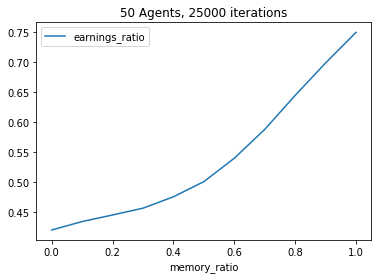

In [97]:
%%time
main_list = []
list_memory_ratio = np.arange(0, 1.1, 0.1).tolist()
list_iterations = [25000]
number_of_agents = [50]
list_arg_pair = list(itertools.product(list_memory_ratio, list_iterations, number_of_agents))

with concurrent.futures.ProcessPoolExecutor(max_workers = 64) as executor:
    for returned_object in executor.map(IPD, list_arg_pair):
        main_list.append(returned_object)

df = pd.DataFrame(main_list, columns = ['memory_ratio', 'earnings_ratio', 'number_of_games', 'memory_size'])
df[['memory_ratio', 'earnings_ratio']].set_index('memory_ratio').sort_index().plot(title = str(number_of_agents[0]) + " Agents, " + str(list_iterations[0]) + " iterations")

CPU times: user 120 ms, sys: 796 ms, total: 916 ms
Wall time: 30min 29s


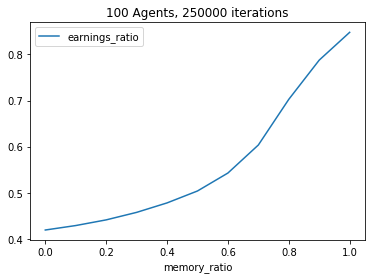

In [100]:
%%time
main_list = []
list_memory_ratio = np.arange(0, 1.1, 0.1).tolist()
list_iterations = [250000]
number_of_agents = [100]
list_arg_pair = list(itertools.product(list_memory_ratio, list_iterations, number_of_agents))

with concurrent.futures.ProcessPoolExecutor(max_workers = 64) as executor:
    for returned_object in executor.map(IPD, list_arg_pair):
        main_list.append(returned_object)

df = pd.DataFrame(main_list, columns = ['memory_ratio', 'earnings_ratio', 'number_of_games', 'memory_size'])
df[['memory_ratio', 'earnings_ratio']].set_index('memory_ratio').sort_index().plot(title = str(number_of_agents[0]) + " Agents, " + str(list_iterations[0]) + " iterations")